In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [2]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:15<00:00, 42.4MB/s]
100% 612M/612M [00:15<00:00, 40.2MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/gtsrb-german-traffic-sign.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

In [5]:
train_ds, valid_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256),
    subset='both',
    validation_split = 0.2,
    seed = 10
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Using 7841 files for validation.


In [6]:
def process(image, label):
  image = tf.cast(image/255, tf.float32)
  return image, label

In [9]:
train_ds.map(process)
valid_ds.map(process)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from keras.backend import dropout
cnn = Sequential([
    Conv2D(128, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)),
    #BatchNormalization(),
    MaxPooling2D(pool_size = (2,2), strides=2, padding = 'valid'),

    Conv2D(256, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size = (2,2), strides=2, padding = 'valid'),

    Conv2D(512, kernel_size = (3,3), padding = 'valid', activation = 'relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size = (2,2), strides=2, padding = 'valid'),

    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(43, activation = 'softmax')
])

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 256)     295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 256)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 512)       1180160   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 512)     

In [ ]:
cnn.compile(optimizer='Adam', loss = 'sparse_categorical_crossentropy', metrics = ['Accuracy'])

In [ ]:
history = cnn.fit(train_ds, epochs = 10, validation_data = valid_ds)

Epoch 1/10
981/981 [==============================] - 295s 298ms/step - loss: 3.7903 - Accuracy: 0.3369 - val_loss: 1.6397 - val_Accuracy: 0.4922
Epoch 2/10
981/981 [==============================] - 291s 297ms/step - loss: 1.4455 - Accuracy: 0.5593 - val_loss: 0.8144 - val_Accuracy: 0.7683
Epoch 3/10
981/981 [==============================] - 292s 297ms/step - loss: 0.9562 - Accuracy: 0.7095 - val_loss: 0.6301 - val_Accuracy: 0.8208
Epoch 4/10
981/981 [==============================] - 290s 296ms/step - loss: 0.7461 - Accuracy: 0.7785 - val_loss: 0.5287 - val_Accuracy: 0.8521
Epoch 5/10
981/981 [==============================] - 290s 296ms/step - loss: 0.6305 - Accuracy: 0.8122 - val_loss: 0.3883 - val_Accuracy: 0.8948
Epoch 6/10
981/981 [==============================] - 290s 295ms/step - loss: 0.5517 - Accuracy: 0.8356 - val_loss: 0.3829 - val_Accuracy: 0.9015
Epoch 7/10
981/981 [==============================] - 289s 294ms/step - loss: 0.4788 - Accuracy: 0.8545 - val_loss: 0.3209 -

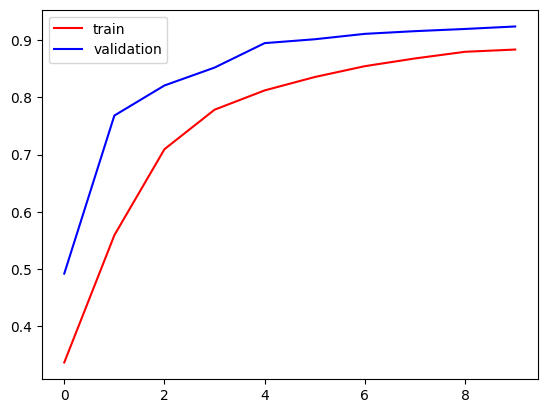

In [ ]:
plt.plot(history.history['Accuracy'],color='red',label='train')
plt.plot(history.history['val_Accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

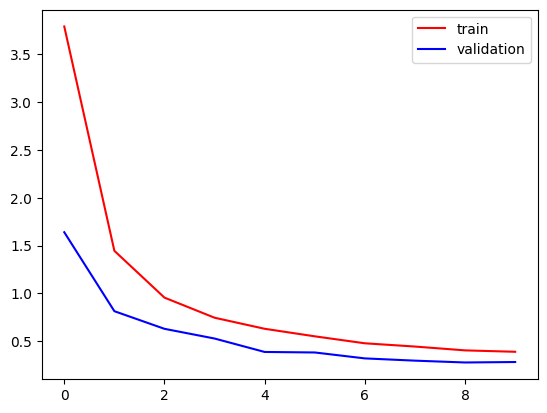

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Transfer Learning

In [ ]:
base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (256, 256, 3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    base,
    Flatten(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(43, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               4194432   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
base.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               4194432   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
model.compile(optimizer='Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(train_ds, epochs = 10, validation_data = valid_ds)

Epoch 1/10
981/981 [==============================] - 212s 199ms/step - loss: 0.5397 - accuracy: 0.8761 - val_loss: 0.1457 - val_accuracy: 0.9681
Epoch 2/10
981/981 [==============================] - 199s 203ms/step - loss: 0.0864 - accuracy: 0.9784 - val_loss: 0.1381 - val_accuracy: 0.9821
Epoch 3/10
981/981 [==============================] - 200s 204ms/step - loss: 0.0543 - accuracy: 0.9863 - val_loss: 0.1413 - val_accuracy: 0.9810
Epoch 4/10
981/981 [==============================] - 200s 204ms/step - loss: 0.0470 - accuracy: 0.9865 - val_loss: 0.1583 - val_accuracy: 0.9866
Epoch 5/10
981/981 [==============================] - 200s 204ms/step - loss: 0.0367 - accuracy: 0.9899 - val_loss: 0.1554 - val_accuracy: 0.9875
Epoch 6/10
981/981 [==============================] - 203s 207ms/step - loss: 0.0314 - accuracy: 0.9909 - val_loss: 0.1277 - val_accuracy: 0.9853
Epoch 7/10
981/981 [==============================] - 204s 208ms/step - loss: 0.0294 - accuracy: 0.9915 - val_loss: 0.1180 -

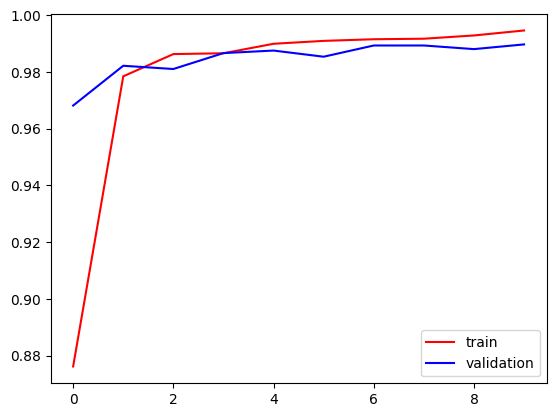

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

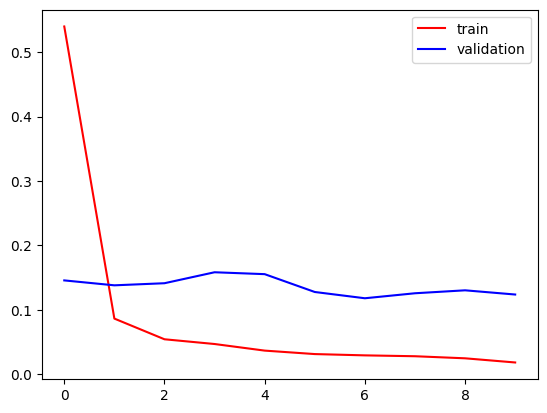

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

Fine Tuning

In [7]:
base_model = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (256, 256, 3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [8]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [11]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [22]:
clf_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(43, activation = 'softmax')
])

In [23]:
clf_model.compile(optimizer='Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [25]:
history = clf_model.fit(train_ds, epochs = 10, validation_data = valid_ds)

Epoch 1/10
981/981 [==============================] - 295s 282ms/step - loss: 0.9729 - accuracy: 0.7489 - val_loss: 0.2282 - val_accuracy: 0.9790
Epoch 2/10
981/981 [==============================] - 233s 238ms/step - loss: 0.0949 - accuracy: 0.9795 - val_loss: 0.4040 - val_accuracy: 0.9864
Epoch 3/10
981/981 [==============================] - 233s 237ms/step - loss: 0.0412 - accuracy: 0.9914 - val_loss: 0.7311 - val_accuracy: 0.9888
Epoch 4/10
981/981 [==============================] - 233s 237ms/step - loss: 0.0343 - accuracy: 0.9913 - val_loss: 1.5687 - val_accuracy: 0.9927
Epoch 5/10
981/981 [==============================] - 233s 237ms/step - loss: 0.0264 - accuracy: 0.9937 - val_loss: 0.0725 - val_accuracy: 0.9819
Epoch 6/10
981/981 [==============================] - 233s 237ms/step - loss: 0.0192 - accuracy: 0.9953 - val_loss: 7.1612 - val_accuracy: 0.9899
Epoch 7/10
981/981 [==============================] - 274s 279ms/step - loss: 0.0165 - accuracy: 0.9957 - val_loss: 2.2030 -